#Подключаем библиотеки


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19 
import torchvision.transforms as transforms

from PIL import Image
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, '../src/')


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


#Подгрузим изображения (почистить тут половину)

In [3]:
def load_image(path, size=None):
    """
    Resize img to size, size should be int and also normalize the
    image using imagenet_stats
    """
    img = Image.open(path)

    if size is not None:
        img = img.resize((size, size))
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    img = transform(img).unsqueeze(0)
    return img


def im_convert(img):
    """
    Convert img from pytorch tensor to numpy array, so we can plot it.
    It follows the standard method of denormalizing the img and clipping
    the outputs
    
    Input:
        img :- (batch, channel, height, width)
    Output:
        img :- (height, width, channel)
    """
    img = img.to('cpu').clone().detach()
    img = img.numpy().squeeze(0)
    img = img.transpose(1, 2, 0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    return img

In [5]:
content_img = load_image('/content/anicont (1).jpg', size=500)
content_img = content_img.to(device)

style_img = load_image('/content/anistyle.jfif.jpg')
style_img = style_img.to(device)

In [7]:
content_img.size(), style_img.size()

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3, 512, 512]))

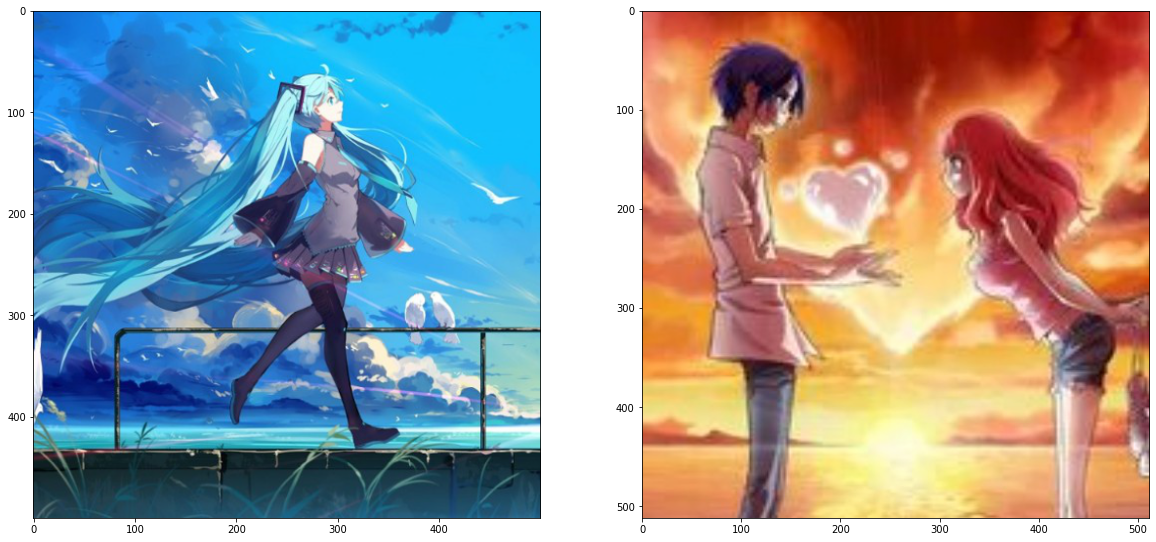

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))
plt.show()

#Создадим модель, как изображено на картинке
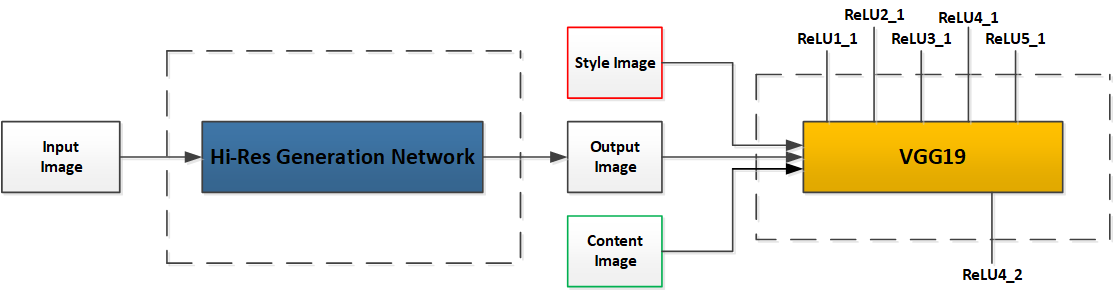

#HRnet 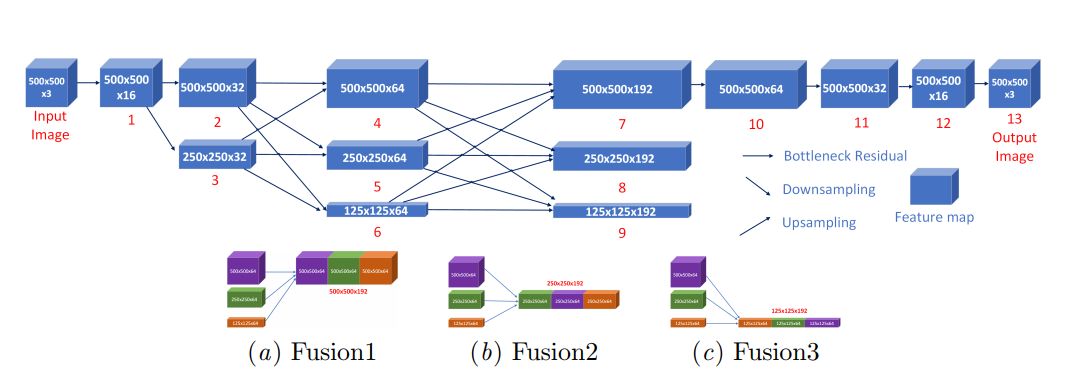

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        num_pad = int(np.floor(kernel_size / 2))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=num_pad)

    def forward(self, x):
        return self.conv(x)

In [10]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.in_c = in_channels
        self.out_c = out_channels
        
        self.identity_block = nn.Sequential(
            ConvLayer(in_channels, out_channels//4, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels//4),
            nn.ReLU(inplace=False),
            ConvLayer(out_channels//4, out_channels//4, kernel_size=kernel_size, stride=stride),
            nn.InstanceNorm2d(out_channels//4),
            nn.ReLU(inplace=False),
            ConvLayer(out_channels//4, out_channels, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=False),
        )
        
        self.shortcut = nn.Sequential(
            ConvLayer(in_channels, out_channels, 1, stride),
            nn.InstanceNorm2d(out_channels),
        )
    
    def forward(self, x):
        out = self.identity_block(x)
        if self.in_c == self.out_c:
            residual = x
        else:
            residual = self.shortcut(x)
        out += residual
        out = F.relu(out)
        return out




In [9]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2, mode='bilinear'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.norm = nn.InstanceNorm2d(out_channels)


    def forward(self, x):
        out = self.conv(x)
        out = F.interpolate(out, scale_factor=self.scale_factor, mode=self.mode, align_corners=False)
        out = self.norm(out)
        out = F.relu(out)
        return out


    

In [11]:
def conv_down(in_c, out_c, stride=2):
    return nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)

def upsample(input, scale_factor):
    return F.interpolate(input=input, scale_factor=scale_factor, mode='bilinear', align_corners=False)


In [12]:
class HRNet(nn.Module):
    """
    For model reference see Figure 2 of the paper https://arxiv.org/pdf/1904.11617v1.pdf.
    
    Naming convention used.
    I refer to vertical layers as a single layer, so from left to right we have 8 layers
    excluding the input image.
    E.g. layer 1 contains the 500x500x16 block
         layer 2 contains 500x500x32 and 250x250x32 blocks and so on
    
    self.layer{x}_{y}:
        x :- the layer number, as explained above
        y :- the index number for that function starting from 1. So if layer 3 has two
             downsample functions I write them as `downsample3_1`, `downsample3_2`
    """
    def __init__(self):
        super().__init__()
        self.layer1_1 = BottleneckBlock(3, 16)
        
        self.layer2_1 = BottleneckBlock(16, 32)
        self.downsample2_1 = conv_down(16, 32)
        
        self.layer3_1 = BottleneckBlock(32, 32)
        self.layer3_2 = BottleneckBlock(32, 32)
        self.downsample3_1 = conv_down(32, 32)
        self.downsample3_2 = conv_down(32, 32, stride=4)
        self.downsample3_3 = conv_down(32, 32)
        
        self.layer4_1 = BottleneckBlock(64, 64)
        self.layer5_1 = BottleneckBlock(192, 64)
        self.layer6_1 = BottleneckBlock(64, 32)
        self.layer7_1 = BottleneckBlock(32, 16)
        self.layer8_1 = conv_down(16, 3, stride=1)
        
    def forward(self, x):
        map1_1 = self.layer1_1(x)
        
        map2_1 = self.layer2_1(map1_1)
        map2_2 = self.downsample2_1(map1_1)
        
        map3_1 = torch.cat((self.layer3_1(map2_1), upsample(map2_2, 2)), 1)
        map3_2 = torch.cat((self.downsample3_1(map2_1), self.layer3_2(map2_2)), 1)
        map3_3 = torch.cat((self.downsample3_2(map2_1), self.downsample3_3(map2_2)), 1)
        
        map4_1 = torch.cat((self.layer4_1(map3_1), upsample(map3_2, 2), upsample(map3_3, 4)), 1)
        
        out = self.layer5_1(map4_1)
        out = self.layer6_1(out)
        out = self.layer7_1(out)
        out = self.layer8_1(out)
        
        return out

In [18]:
def gram_matrix(img):
    b, c, h, w = img.size()
    img = img.view(b*c, h*w)
    G = torch.mm(img, img.t())
    return G

In [13]:
def get_features(img, model, layers=None):
    """
    Use VGG19 to extract features from the intermediate layers.
    """
    if layers is None:
        layers = {
            '0': 'conv1_1',   # style layer
            '5': 'conv2_1',   # style layer
            '10': 'conv3_1',  # style layer
            '19': 'conv4_1',  # style layer
            '28': 'conv5_1',  # style layer
            
            '21': 'conv4_2'   # content layer
        }
    
    features = {}
    x = img
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


In [14]:
cfg = {
    'lr': 5e-3,
    'show_every': 100,
    'steps': 1000,
    'step_size': 200,
    'gamma': 0.9
}


In [16]:
def train_model(device, cfg=cfg,content_img=content_img, style_img=style_img):
    # Load VGG19 features
    torch.autograd.set_detect_anomaly(True)
    vgg = vgg19(pretrained=True).features
    vgg = vgg.to(device)
    # We don't want to train VGG
    for param in vgg.parameters():
        param.requires_grad_(False)
        
    # Load style net
    style_net = HRNet()
    style_net = style_net.to(device)
    
    # Load images

    # Get features from VGG
    content_features = get_features(content_img, vgg)
    style_features = get_features(style_img, vgg)
    target = content_img.clone().requires_grad_(True).to(device)
    style_gram_matrixs = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    optim = torch.optim.Adam(style_net.parameters(), lr=cfg['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=cfg['step_size'], gamma=cfg['gamma'])

    content_loss_epoch = []
    style_loss_epoch = []
    total_loss_epoch = []
    i = 0
    output_image = content_img
    content_weight = 150
    style_weight = 1

    
    style_weights = {
    'conv1_1': 0.1,
    'conv2_1': 0.2,
    'conv3_1': 0.4,
    'conv4_1': 0.8,
    'conv5_1': 1.6,
    }

    # Start training
    for epoch in tqdm(range(cfg['steps']+1)):
        scheduler.step()

        target = style_net(content_img).to(device)
        target.requires_grad_(True)
        
        target_features = get_features(target, vgg)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
        
        style_loss = 0
        
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram_matrix = gram_matrix(target_feature)
            style_gram_matrix = style_gram_matrixs[layer]
            
            layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
            b, c, h, w = target_feature.shape
            style_loss += layer_style_loss / (c*h*w)
            
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss_epoch.append(total_loss.item())
        
        style_loss_epoch.append(style_weight * style_loss)
        content_loss_epoch.append(content_weight * content_loss.item())
        
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        if epoch % cfg['show_every'] == 0:
            print("After %d criterions:" % epoch)
            print('Total loss: ', total_loss.item())
            print('Content loss: ', content_loss.item())
            print('Style loss: ', style_loss.item())
            plt.imshow(im_convert(target))
            plt.show()

            # plt.savefig(f'{args.save_dir}fig{i}.png')
            # i += 1

        output_image = target

In [19]:
train_model(device, content_img=content_img, style_img=style_img)

  0%|          | 0/1001 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/1001 [00:00<?, ?it/s]


RuntimeError: ignored